In [1]:
import os
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = Path(os.environ["DATA_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
results_path = Path(os.environ["RESULTS_PATH"])

<Axes: >

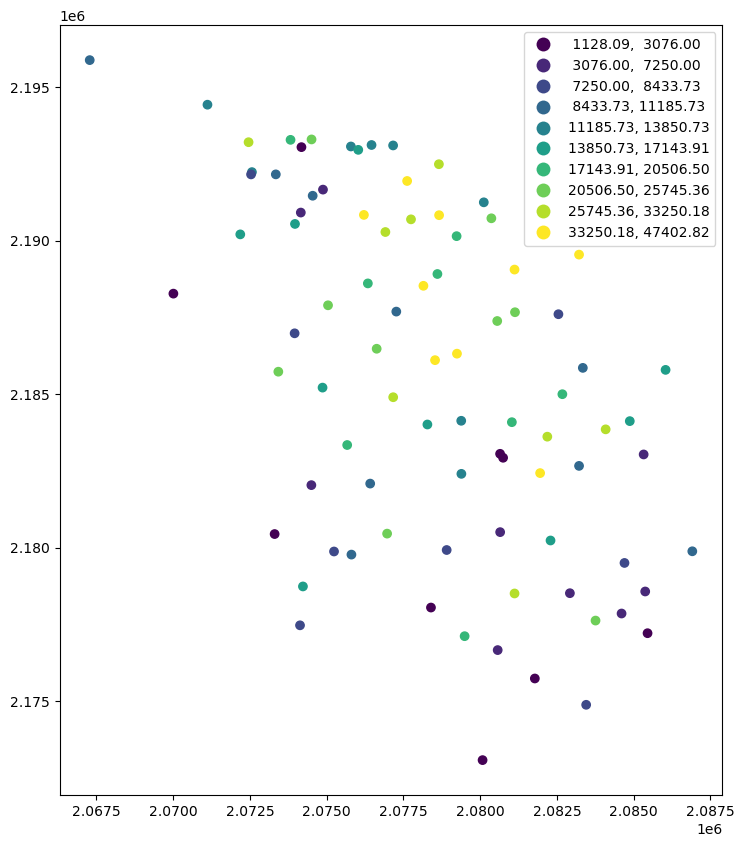

In [3]:

df_estaciones = gpd.read_file(
    data_path / "datos" / "aforos_vehiculares.gpkg").to_crs("EPSG:6372")

years = ['2014', '2015', '2016', '2017', '2018',
         '2019', '2020', '2021', '2022', '2023', '2024']
cols = [f'TDPA_{year}' for year in years]
df_estaciones[years] = df_estaciones[cols].replace(0, np.nan)
df_estaciones['TDPA_mean'] = df_estaciones[cols].mean(axis=1)
df_estaciones.plot(column='TDPA_mean', scheme='quantiles',
                   k=10, legend=True, figsize=(10, 10))

array([[<Axes: title={'center': 'TDPA_mean'}>]], dtype=object)

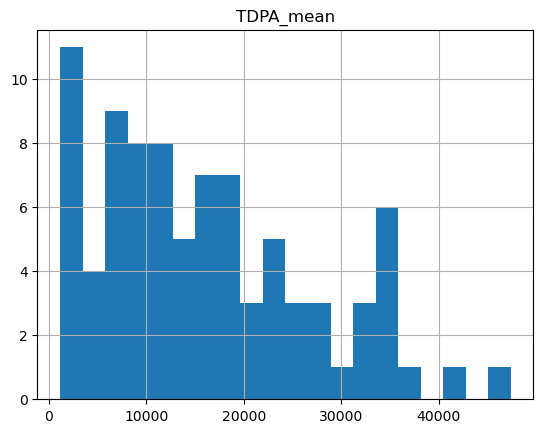

In [4]:
df_estaciones.hist(column='TDPA_mean', bins=20)

In [5]:
gdf_vialidades = gpd.read_file(
    "data/NAD/datos/SAP_Vialildad_Primaria.geojson").to_crs("EPSG:6372")
gdf_vialidades = gdf_vialidades.dissolve(by=['NOMBRE_DE_']).reset_index()

# toma el promedio del trafico vehicular de las estaciones cercanas a cada vialidad
street_mean_tdpa = (
    gpd.sjoin_nearest(
        df_estaciones[["Id", "TDPA_mean", "geometry"]],
        gdf_vialidades[["ID", "geometry"]],
        how="left",
        distance_col="dist_to_street",
        max_distance=20
    )
    .groupby('ID')['TDPA_mean']
    .median()
    .reset_index()
)
gdf_vialidades = gdf_vialidades.merge(street_mean_tdpa, on='ID', how='left')

<Axes: >

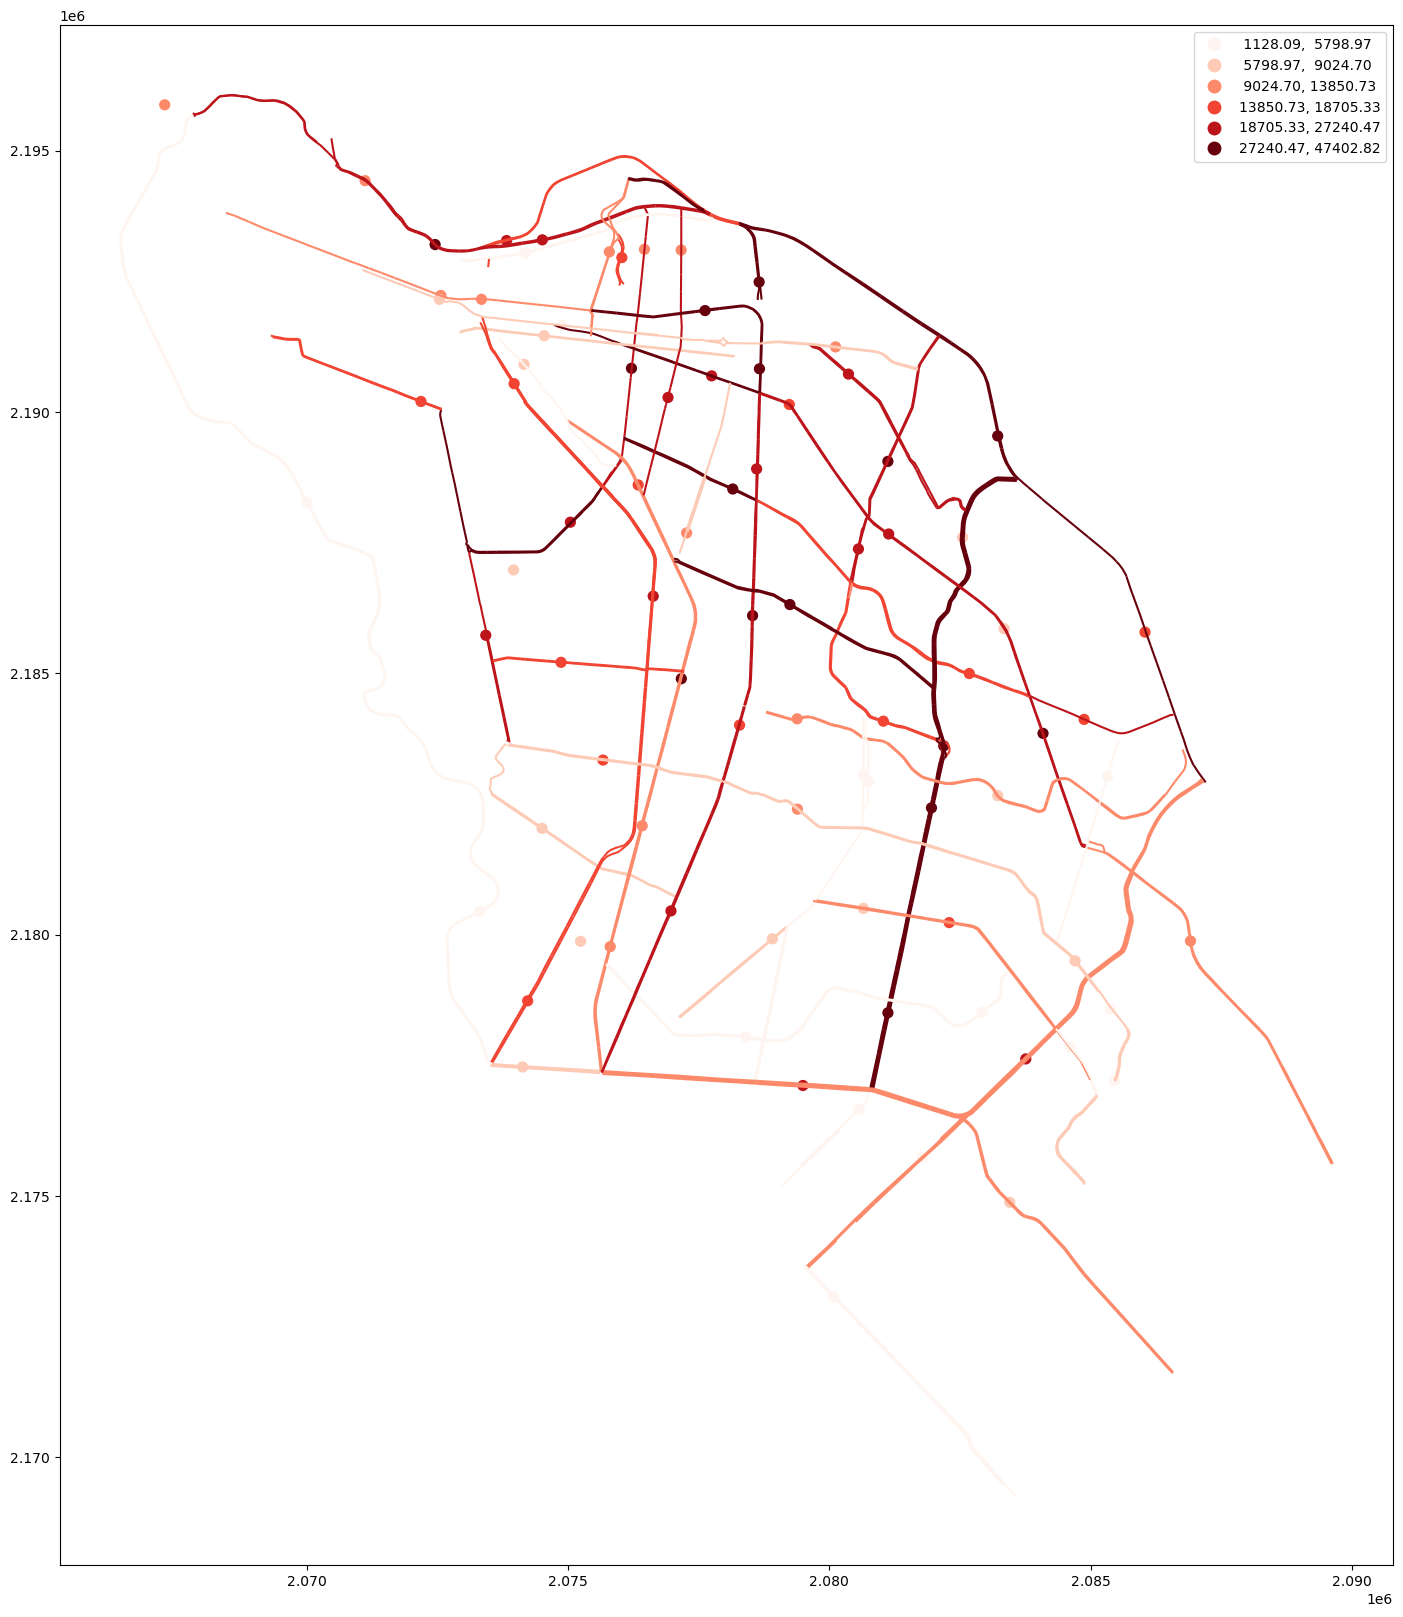

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
gdf_vialidades.plot(column='TDPA_mean', ax=ax, cmap='Reds', scheme='quantiles', k=6)
df_estaciones.plot(ax=ax, column='TDPA_mean', legend=True, cmap='Reds', markersize=50, scheme='quantiles', k=6)

In [7]:
def calculate_tdpa_exposure(df: gpd.GeoDataFrame, df_streets: gpd.GeoDataFrame, threshold_km: int = 500):
    df_temp = df.copy().reset_index()
    dist_cols = [f'distance_{row["ID"]}' for index,
                 row in df_streets.iterrows()]
    # get distance from blocks to all major streets
    df_temp[dist_cols] = df_temp.geometry.centroid.apply(
        lambda g: df_streets.geometry.distance(g))

    df_temp = pd.melt(df_temp[['id', 'geometry', *dist_cols]], id_vars=[
                      'id', 'geometry'], var_name='station_id', value_name='distance_km')
    df_temp['station_id'] = df_temp['station_id'].replace(
        {'distance_': ''}, regex=True).astype(int)
    df_temp = df_temp.merge(
        df_streets[['ID', 'TDPA_mean']], left_on='station_id', right_on='ID', how='left')

    results = {}
    for cve, group in df_temp.groupby("id"):
        close = group[group["distance_km"] <= threshold_km]

        if not close.empty:
            value = close["TDPA_mean"].sum() / threshold_km
        else:
            min_dist = group["distance_km"].min()
            closest = group[group["distance_km"] == min_dist]
            value = closest["TDPA_mean"].sum() / min_dist

        results[cve] = value

    return pd.Series(results)

In [8]:
import geopandas as gpd
from pathlib import Path

df_agebs = (
    gpd.read_file(
        population_grids_path
        / "08.2.03.gpkg",
    )
    .drop(columns=["POBTOT"])
    .rename(columns={"CVEGEO": "id"})
    .set_index("id")
)
df_colonias = (
    gpd.read_file(data_path / "datos" / "colonias.geojson")
    .to_crs("EPSG:6372")
    .rename(columns={"ID": "id"})
    .set_index("id")
)

df_agebs['tdpa_density'] = calculate_tdpa_exposure(
    df_agebs, gdf_vialidades, threshold_km=500)
df_colonias['tdpa_density'] = calculate_tdpa_exposure(
    df_colonias, gdf_vialidades, threshold_km=500)

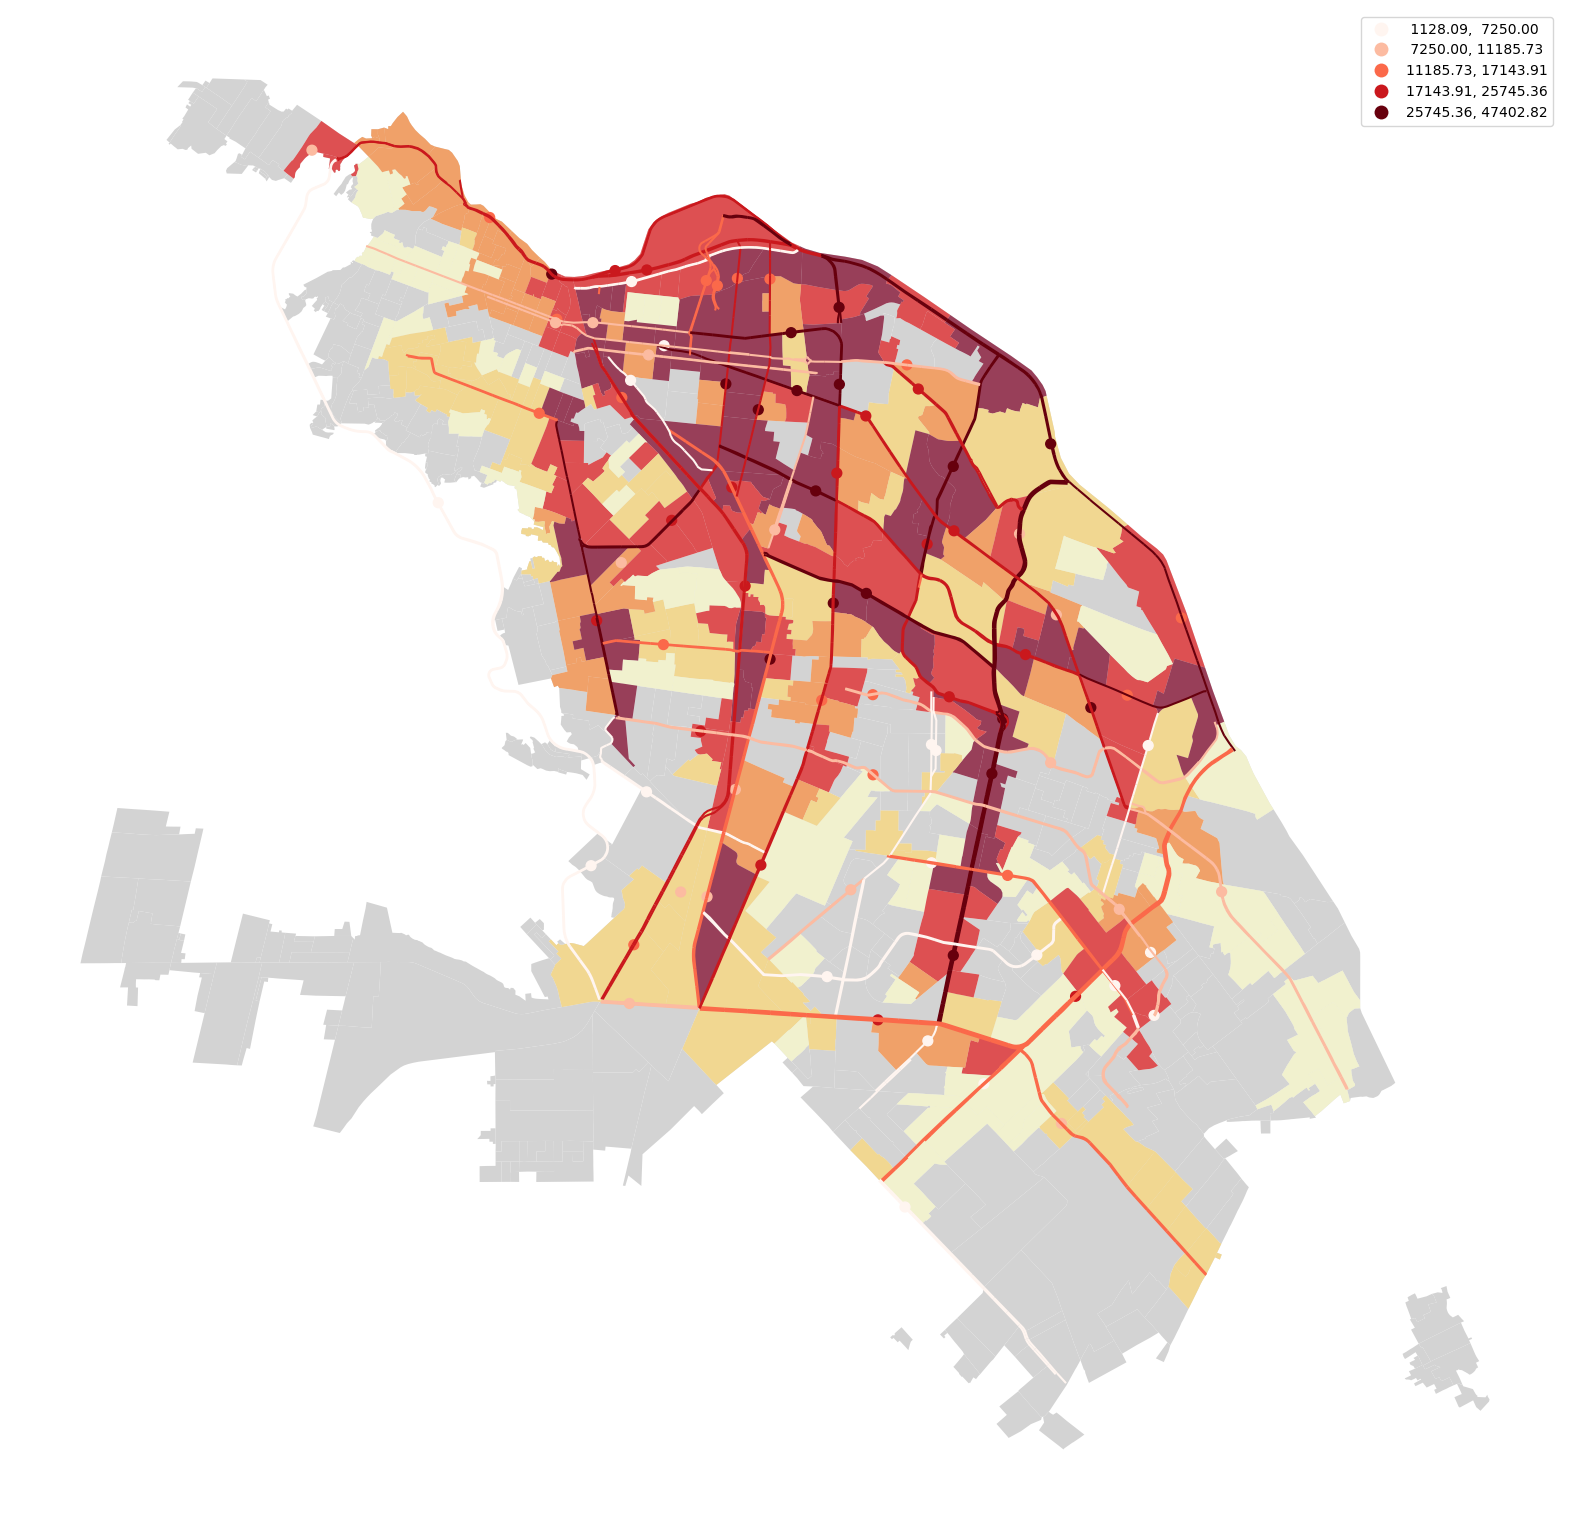

In [9]:
quantiles = df_agebs['tdpa_density'].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 1])
df_agebs['tdpa_density_q'] = df_agebs['tdpa_density'].apply(lambda x: quantiles[quantiles <= x].max())
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_axis_off()
df_agebs.plot(color='lightgray', ax=ax)
df_agebs.plot(column='tdpa_density_q', scheme='quantiles', cmap='YlOrRd', k=5, legend=True, ax=ax, alpha=0.7)
gdf_vialidades.plot(ax=ax, column='TDPA_mean', cmap='Reds', scheme='quantiles', k=5)
df_estaciones.plot(ax=ax, column='TDPA_mean', legend=True, cmap='Reds', markersize=50, scheme='quantiles', k=5)
plt.show()

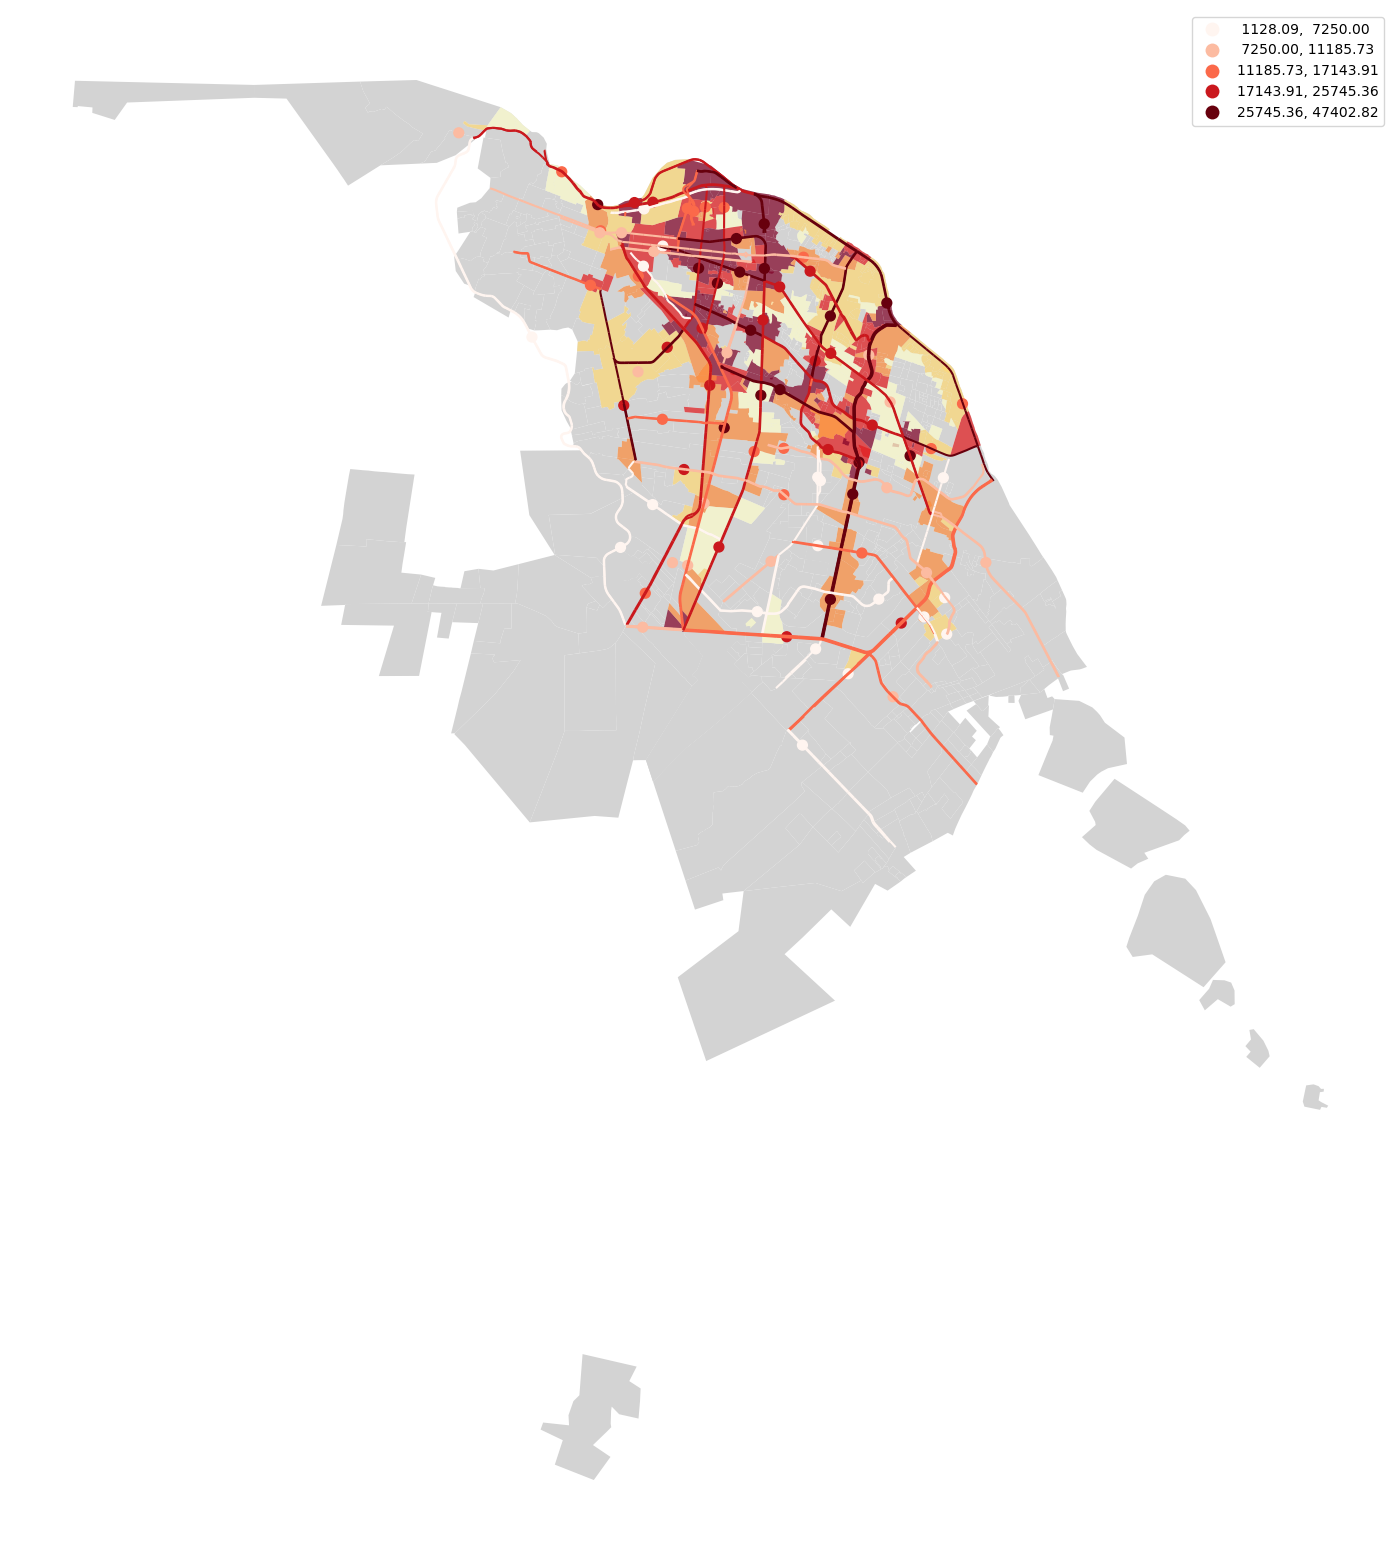

In [10]:
quantiles = df_colonias['tdpa_density'].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 1])
df_colonias['tdpa_density_q'] = df_colonias['tdpa_density'].apply(lambda x: quantiles[quantiles <= x].max())
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_axis_off()
df_colonias.plot(color='lightgray', ax=ax)
df_colonias.plot(column='tdpa_density_q', scheme='quantiles', cmap='YlOrRd', k=5, legend=True, ax=ax, alpha=0.7)
gdf_vialidades.plot(ax=ax, column='TDPA_mean', cmap='Reds', scheme='quantiles', k=5)
df_estaciones.plot(ax=ax, column='TDPA_mean', legend=True, cmap='Reds', markersize=50, scheme='quantiles', k=5)
plt.show()

In [11]:
df_colonias[['tdpa_density']].reset_index().to_parquet(
    results_path / "tdpa_colonias.parquet")
df_agebs[['tdpa_density']].reset_index().to_parquet(
    results_path / "tdpa_agebs.parquet")